# Coronavirus Data Analysis

In [1]:
%matplotlib notebook

# Module to send http requests
from requests import get

import matplotlib.pyplot as plt
import pandas as pd
from random import sample
from datetime import date
import statistics as stats

In [2]:
# Read table of population estimates (ONS Apr 2020)
df_populations = pd.read_csv('populationestimates2020.csv', header=1)
df_populations['Population'] = df_populations['All ages'].replace(',','',regex=True).fillna(0).astype(int)
df_populations.drop(columns='All ages', inplace=True)

# Read the list of upper tier local authorities and make a dataframe of their populations
df_utlas = pd.read_csv('utlas.csv', names=["Name"])
df_utla_populations = df_utlas.merge(df_populations, how='left', on="Name")
df_utla_populations.rename(columns = {"Geography1":"Geography"})

,Name,Code,Geography,Population
0,Antrim and Newtownabbey,N09000001,Local Government District,143504.0
1,Ards and North Down,N09000011,Local Government District,161725.0
2,"Armagh City, Banbridge and Craigavon",N09000002,Local Government District,216205.0
3,Barking and Dagenham,E09000002,London Borough,212906.0
4,Barnet,E09000003,London Borough,395869.0
...,...,...,...,...
177,Wokingham,E06000041,Unitary Authority,171119.0
178,Wolverhampton,E08000031,Metropolitan District,263357.0
179,Worcestershire,E10000034,County,595786.0
180,Wrexham,W06000006,Unitary Authority,135957.0


In [3]:
def rolling_average(values, over):
    """Perform a rolling average on the set of values, returning a list of the same length as values."""
    result = []
    for i in range(over-1):
        result.append(None)
    for i in range(len(values)-over+1):
        result.append(stats.mean(values[i:i+over]))
    return result

In [4]:
def get_response(url):
    """Perform a http GET request at the given url, returning the response json."""
    response = get(endpoint, timeout=10)
    if response.status_code >= 400:
      raise RuntimeError(f'Request failed: { response.text }')
    return response.json()

In [5]:
def join_on_date(dfs):
    """Joins a dictionary of dataframes, where the key is used as the suffix when producting a larger dataframe joining the two."""
    result = pd.DataFrame()
    for suffix, df in dfs.items():
        if result.empty:
            result = df.rename(columns={f"date{suffix.replace(' ','')}":'date'})
        else:
            result = result.merge(df, left_on='date', right_on=f"date{suffix.replace(' ','')}")
            result['date'].fillna(result[f"date{suffix.replace(' ','')}"], inplace=True)
            del result[f"date{suffix.replace(' ','')}"]
    result['date'] = result['date'].map(date.fromisoformat)
    return result

In [6]:
nations = ['England', 'Scotland', 'Wales', 'Northern Ireland']

nation_dfs = {}
for nation in nations:
    print(f'processing {nation}')
    endpoint = (
      'https://api.coronavirus.data.gov.uk/v1/data?'
      f'filters=areaType=nation;areaName={nation}&'
      'structure={"date":"date","newCases":"newCasesByPublishDate", "newDeaths":"newDeaths28DaysByPublishDate"}'
    )
    data = get_response(endpoint)
    nation_dfs[nation] = pd.DataFrame(data['data'])\
                                .sort_values('date')\
                                .reset_index(drop=True)\
                                .add_suffix(nation.replace(' ',''))


processing England
processing Scotland
processing Wales
processing Northern Ireland


In [7]:
joined_data_nations = join_on_date(nation_dfs)

In [8]:
# joined_data_nations.to_csv('data_backup_nations.csv')

In [9]:
for nation in nations:
    population_in_millions = int(df_populations[df_populations['Name']==nation.upper()]['Population']) / 10**6
    new_cases = joined_data_nations[f"newCases{nation.replace(' ','')}"]
    new_cases_per_million = joined_data_nations[f"newCases{nation.replace(' ','')}"] / population_in_millions
    new_deaths_per_million = joined_data_nations[f"newDeaths{nation.replace(' ','')}"] / population_in_millions
    rolling_new_cases_per_million = rolling_average(new_cases_per_million,7)
    rolling_new_deaths_per_million = rolling_average(new_deaths_per_million,7)
    
    joined_data_nations[f"newCasesPerMillion{nation.replace(' ','')}"] = new_cases_per_million
    joined_data_nations[f"newDeathsPerMillion{nation.replace(' ','')}"] = new_deaths_per_million
    joined_data_nations[f"newCasesPerMillion7Day{nation.replace(' ','')}"] = rolling_new_cases_per_million
    joined_data_nations[f"newDeathsPerMillion7Day{nation.replace(' ','')}"] = rolling_new_deaths_per_million

nation_new_cases_columns = [f"newCasesPerMillion7Day{nation.replace(' ','')}" for nation in nations]
nation_new_deaths_columns =  [f"newDeathsPerMillion7Day{nation.replace(' ','')}" for nation in nations]

joined_data_nations.plot('date', nation_new_cases_columns)
plt.legend(labels=nations)
plt.title('New Cases per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')

joined_data_nations.plot('date', nation_new_deaths_columns)
plt.legend(labels=nations)
plt.title('New Deaths per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([737425., 737456., 737485., 737516., 737546., 737577., 737607.,
        737638., 737669.]),
 <a list of 9 Text major ticklabel objects>)

In [10]:
# To plot different Upper tier local authorities, simply add their name to this list.
# utlas = ['Cheshire West and Chester','Leicester','Northumberland','North Yorkshire', 'Wirral', 'Oxfordshire', 'Cumbria']
# utlas = ['Bolton', 'Bradford', 'Blackburn with Darwen']
utlas = list(df_utlas['Name'])


utla_dfs = {}
for utla in utlas:
    try:
        print(f'processing {utla}')
        endpoint = (
          'https://api.coronavirus.data.gov.uk/v1/data?'
          f'filters=areaType=utla;areaName={utla}&'
          'structure={"date":"date","newCases":"newCasesBySpecimenDate"}'
        )
        data = get_response(endpoint)
        utla_dfs[utla] = pd.DataFrame(data['data'])\
                                    .sort_values('date')\
                                    .reset_index(drop=True)\
                                    .add_suffix(utla.replace(' ',''))
    except:
        utlas.remove(utla)
        print("Failed, moving on.")

processing Antrim and Newtownabbey
processing Ards and North Down
processing Armagh City, Banbridge and Craigavon
processing Barking and Dagenham
processing Barnet
Failed, moving on.
processing Bath and North East Somerset
processing Bedford
processing Belfast
processing Bexley
processing Birmingham
processing Blackburn with Darwen
processing Blackpool
processing Blaenau Gwent
processing Bolton
processing Bournemouth, Christchurch and Poole
processing Bracknell Forest
processing Bradford
processing Brent
processing Bridgend
processing Brighton and Hove
processing Bristol, City of
processing Bromley
processing Buckinghamshire
processing Bury
processing Caerphilly
processing Calderdale
Failed, moving on.
processing Camden
processing Cardiff
processing Carmarthenshire
processing Causeway Coast and Glens
processing Central Bedfordshire
processing Ceredigion
processing Cheshire East
processing Cheshire West and Chester
processing Conwy
processing Cornwall and Isles of Scilly
processing Coun

In [11]:
joined_data_utlas = join_on_date(utla_dfs)
# Remove the last 2 days to mitigate reporting delay using Specimen date
joined_data_utlas.drop(index=[len(joined_data_utlas)-1, len(joined_data_utlas)-2], inplace=True)

In [16]:
# joined_data_utlas.to_csv('data_backup_utlas.csv')
print(joined_data_utlas['newCasesPerMillion7DaySwansea'].head())

KeyError: 'newCasesPerMillion7DaySwansea'

Failed processing Plymouth, removing it.


<IPython.core.display.Javascript object>


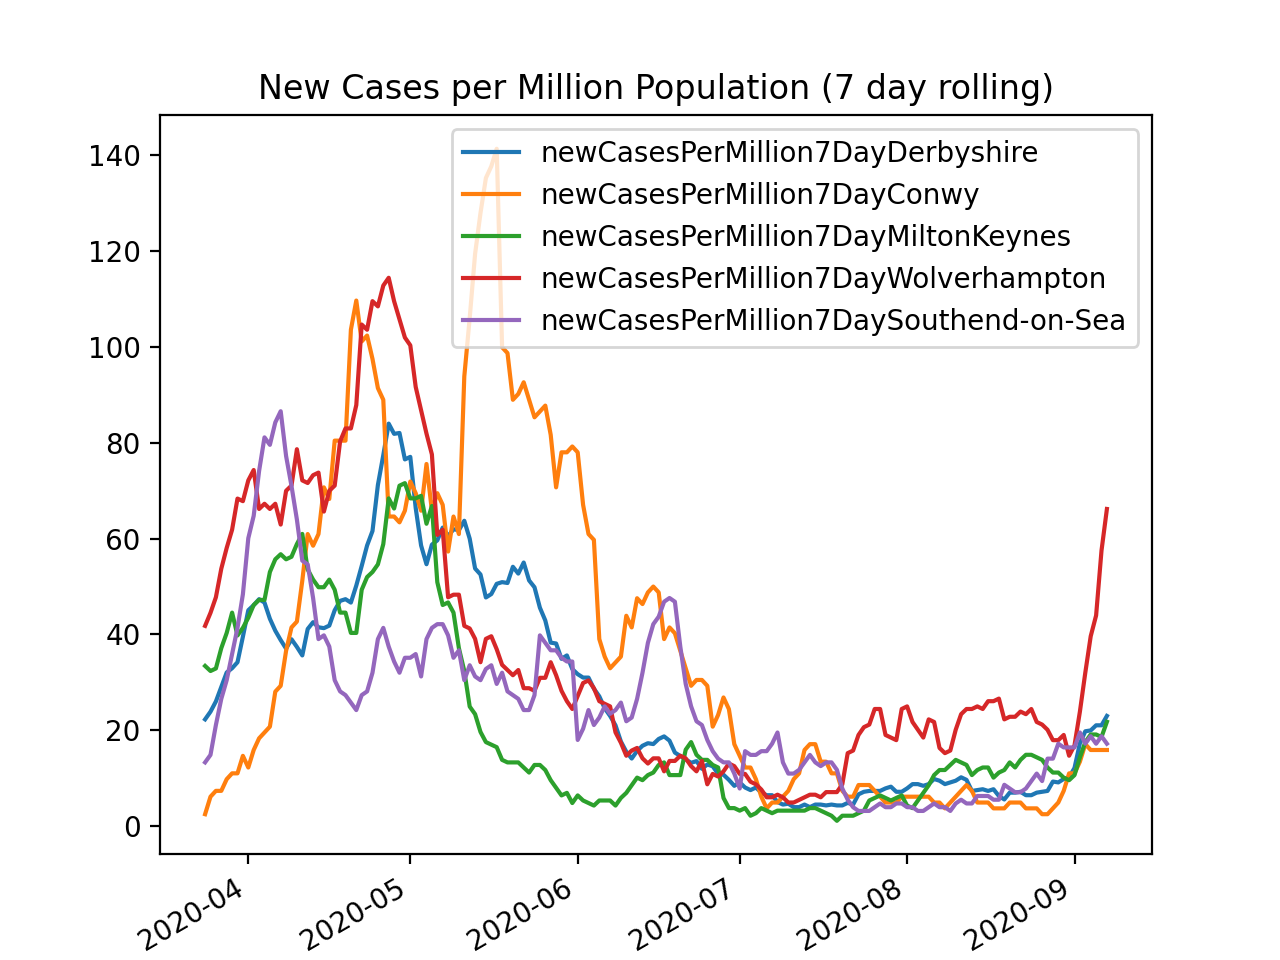

(array([737516., 737546., 737577., 737607., 737638., 737669.]),
 <a list of 6 Text major ticklabel objects>)

In [18]:
for utla in utlas:
    try:
        population_in_millions = int(df_utla_populations[df_utla_populations['Name']==utla]['Population']) / 10**6
        new_cases_per_million = joined_data_utlas[f"newCases{utla.replace(' ','')}"]/population_in_millions
        rolling_new_cases_per_million = rolling_average(new_cases_per_million,7)
        joined_data_utlas[f"newCasesPerMillion{utla.replace(' ','')}"] = new_cases_per_million
        joined_data_utlas[f"newCasesPerMillion7Day{utla.replace(' ','')}"] = rolling_new_cases_per_million
    except:
        print(f'Failed processing {utla}, removing it.')
        utlas.remove(utla)

<IPython.core.display.Javascript object>


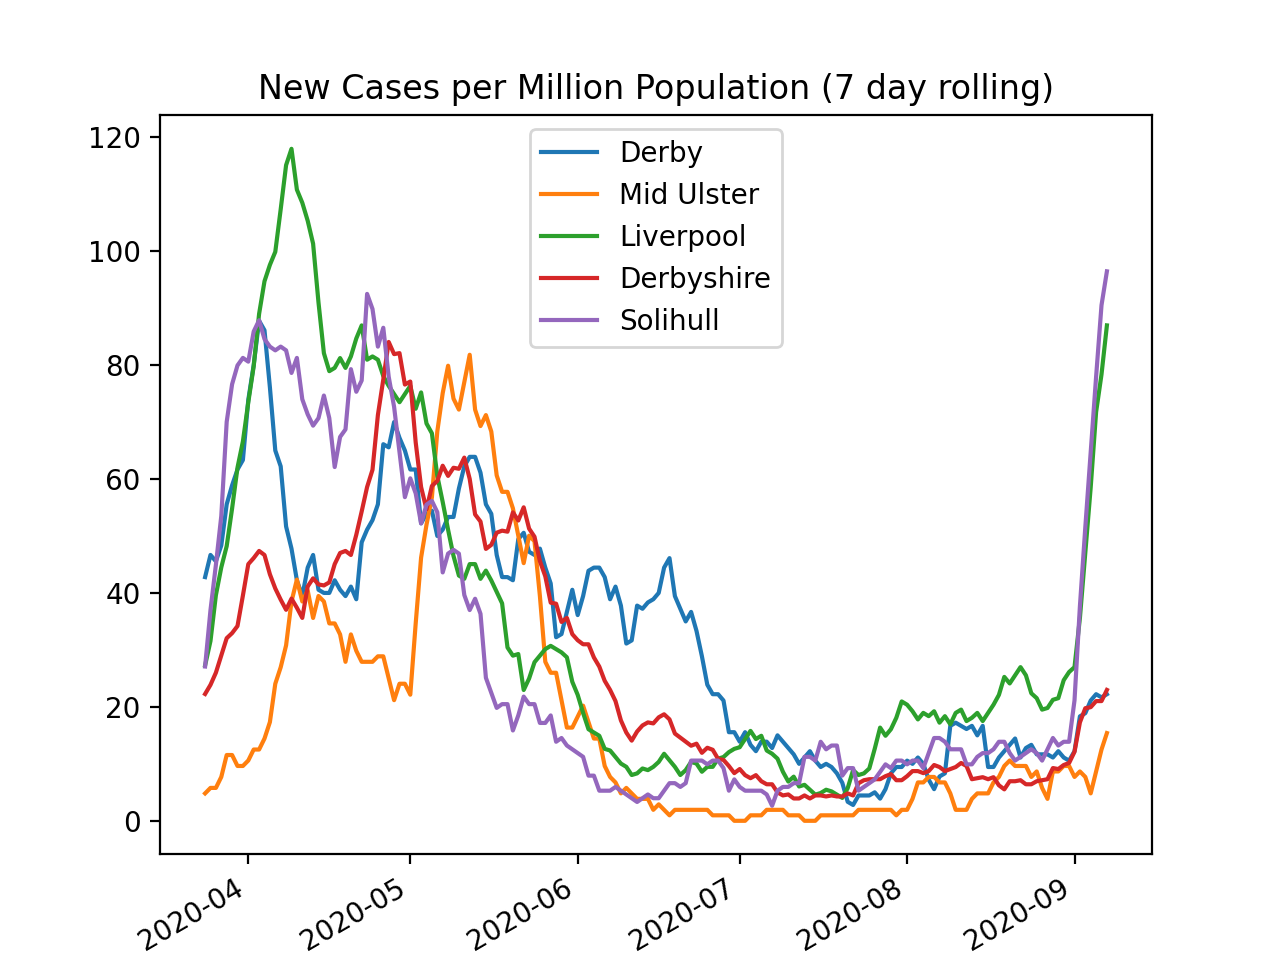

(array([737516., 737546., 737577., 737607., 737638., 737669.]),
 <a list of 6 Text major ticklabel objects>)

In [25]:
# utlas_new_cases_columns = [f"newCasesPerMillion7Day{utla.replace(' ','')}" for utla in utlas]
utla_sample = sample(utlas,5)
utlas_new_cases_columns = [f"newCasesPerMillion7Day{utla.replace(' ','')}" for utla in utla_sample]

joined_data_utlas.plot('date', utlas_new_cases_columns)
plt.legend(labels=utla_sample)
plt.title('New Cases per Million Population (7 day rolling)')
plt.xticks(rotation=30, ha='right')